In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

from astropy.io import fits, ascii
from astropy.table import Table,join
from astropy.table import vstack as vstack_table

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')
import sys
org_stdout = sys.stdout # Save a reference to the original standard output

import math
from IPython.display import display, HTML
%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [3]:
import sys, os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1



import time
from astropy.io.fits.column import _parse_tdim
import numpy as np
import argparse
from copy import deepcopy as copy
from pprint import pprint

# pyFIT3D dependencies
from pyFIT3D.common.io import clean_preview_results_files, print_time, read_spectra

# 18.11.2023
# So far we were ysing the auto_ssp_tools from pyFIT3D
# We will attempt to modify them
#from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main
from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_single_main

from pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from pyFIT3D.common.io import clean_preview_results_files, print_time, read_spectra

from pyFIT3D.common.gas_tools import detect_create_ConfigEmissionModel
from pyFIT3D.common.io import create_ConfigAutoSSP_from_lists
from pyFIT3D.common.io import create_emission_lines_file_from_list
from pyFIT3D.common.io import create_emission_lines_mask_file_from_list
#from pyFIT3D.common.tools import read_coeffs_CS

from lvmdap.modelling.synthesis import StellarSynthesis
from lvmdap.modelling.auto_rsp_tools import ConfigAutoSSP
from lvmdap.modelling.auto_rsp_tools import model_rsp_elines_single_main

from lvmdap.dap_tools import load_LVM_rss, read_PT, rsp_print_header, plot_spec, read_rsp
from lvmdap.dap_tools import plot_spectra, read_coeffs_RSP, read_elines_RSP, read_tab_EL
from lvmdap.dap_tools import find_redshift_spec
from lvmdap.flux_elines_tools import flux_elines_RSS_EW

from scipy.ndimage import gaussian_filter1d,median_filter

from astropy.table import Table
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from astropy.io import fits, ascii

import yaml
import re
from collections import Counter

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP

#
# Just for tests
#
# import matplotlib.pyplot as plt


CWD = os.path.abspath(".")
EXT_CHOICES = ["CCM", "CAL"]
EXT_CURVE = EXT_CHOICES[0]
EXT_RV = 3.1
N_MC = 20


In [4]:
ref_file="../Oct2023/output_dap/dap-00006109.output.fits.gz"
ref_file="output_dap/dap-test-00006109.output.fits.gz"
hdu=fits.open(ref_file)
#print(hdu.header["NAXIS1"])

In [5]:
print(hdu[0].data.shape)

(6, 361, 12401)


In [6]:
print(hdu[0].header["NAXIS1"])
print(hdu[0].header["NAXIS2"])
print(hdu[0].header["NAXIS3"])
print(hdu[0].header["CRVAL1"])

12401
361
6
3600.0


In [7]:
wave = hdu[0].header["CRVAL1"]+hdu[0].header["CDELT1"]*(np.arange(hdu[0].header["NAXIS1"]))#-hdu[0].header["CRPIX1"])

In [8]:
print(wave)

[3600.  3600.5 3601.  ... 9799.  9799.5 9800. ]


(6500.0, 6800.0)

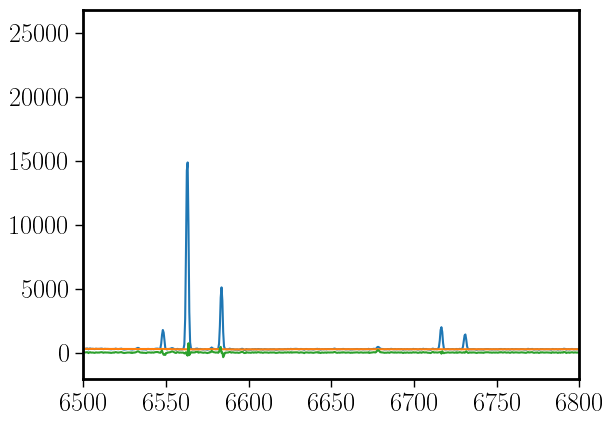

In [9]:
plt.plot(wave,hdu[0].data[0,100,:])
plt.plot(wave,hdu[0].data[1,100,:])
plt.plot(wave,hdu[0].data[4,100,:])
plt.xlim(6500,6800)

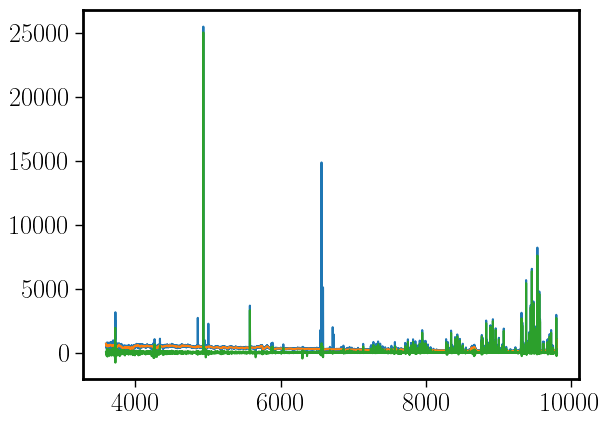

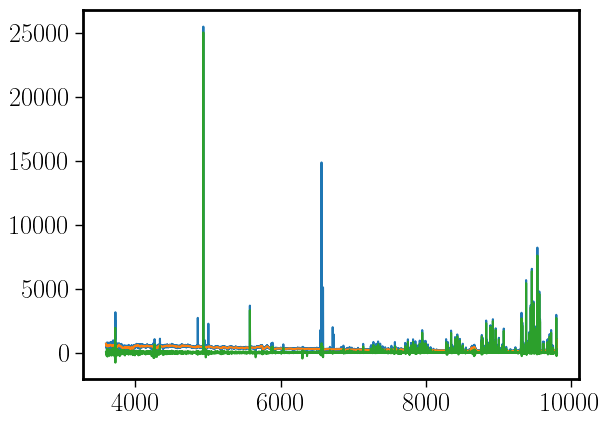

In [10]:
plt.plot(wave,hdu[0].data[0,100,:])
plt.plot(wave,hdu[0].data[1,100,:])
plt.plot(wave,hdu[0].data[4,100,:])


In [11]:
i_spec=100
org_spec = hdu[0].data[0,i_spec,:]
mod_spec = hdu[0].data[1,i_spec,:]
res_spec = hdu[0].data[4,i_spec,:]

In [12]:
cmd_args=('junk','junk', 'lvm-dap_all.yaml')

parser = argparse.ArgumentParser(
    description="lvm-dap-yaml LVM_FILE OUTPUT_LABEL CONFIG.YAML"
)
parser.add_argument(
    "lvm_file", metavar="lvm_file",
    help="input LVM spectrum to fit"
)

parser.add_argument(
    "label",
    help="string to label the current run"
)

parser.add_argument(
    "config_yaml",
    help="config_yaml with the fitting parameters"
)
parser.add_argument(
    "-d", "--debug",
    help="debugging mode. Defaults to false.",
    action="store_true"
)

args = parser.parse_args(cmd_args)

with open(args.config_yaml, 'r') as yaml_file:
    dap_config_args = yaml.safe_load(yaml_file)
print(dap_config_args)

dict_param={}
for k, v in dap_config_args.items():
    if(isinstance(v, str)):
        v=v.replace("..",dap_config_args['lvmdap_dir'])
        dict_param[k]=v
    parser.add_argument(
        '--' + k, default=v
    )

parser.add_argument(
    "--flux-scale", metavar=("min","max"), type=np.float, nargs=2,
    help="scale of the flux in the input spectrum",
    default=[-1, +1]
)

parser.add_argument(
    "--plot", type=np.int,
    help="whether to plot (1) or not (0, default) the fitting procedure. If 2, a plot of the result is store in a %%file without display on screen",
    default=0
)





args = parser.parse_args(cmd_args)

#print(args)

{'output_path': '/disk-a/sanchez/LVM/LVM/ver_231113/output_dap/', 'lvmdap_dir': '/home/sanchez/sda2/code/python/lvmdap', 'rsp-file': '/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-30.fits.gz', 'sigma-inst': 1, 'rsp-nl-file': '/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-5.fits.gz', 'input-fmt': 'rss', 'redshift': [0.0, 0.0001, -0.0003, 0.0003], 'sigma': [1, 10, 1, 70], 'AV': [0, 0.3, 0.0, 1.5], 'emission-lines-file': '../_legacy/emission_lines_strong.LVM', 'emission-lines-file-long': '../_legacy/emission_lines_strong.LVM', 'w-range': [3800, 7000], 'mask-file': '../_legacy/mask_bands_LVM.txt', 'config-file': '../_legacy/auto_ssp_LVM.config', 'clear_outputs': True, 'w-range-nl': [3800, 4000], 'bin-nl': 3, 'bin-AV': 50, 'mask_file': 'none', 'ignore_gas': False, 'single-gas-fit': True, 'sigma-gas': 0.8, 'flux-scale-org': [-1, 1], 'single_rsp': False, 'do_plots': 1, 'only_integrated': False, 'out_plot_format': 'pdf', 'SN_CUT': 20, 'sky_hack': True, 'auto_redshift': True

/tmp/ipykernel_180287/2537708860.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "--flux-scale", metavar=("min","max"), type=np.float, nargs=2,
/tmp/ipykernel_180287/2537708860.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#de

In [13]:
print(args)

Namespace(lvm_file='junk', label='junk', config_yaml='lvm-dap_all.yaml', debug=False, output_path='/disk-a/sanchez/LVM/LVM/ver_231113/output_dap/', lvmdap_dir='/home/sanchez/sda2/code/python/lvmdap', rsp_file='/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-30.fits.gz', sigma_inst=1, rsp_nl_file='/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-5.fits.gz', input_fmt='rss', redshift=[0.0, 0.0001, -0.0003, 0.0003], sigma=[1, 10, 1, 70], AV=[0, 0.3, 0.0, 1.5], emission_lines_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/emission_lines_strong.LVM', emission_lines_file_long='/home/sanchez/sda2/code/python/lvmdap/_legacy/emission_lines_strong.LVM', w_range=[3800, 7000], mask_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/mask_bands_LVM.txt', config_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/auto_ssp_LVM.config', clear_outputs=True, w_range_nl=[3800, 4000], bin_nl=3, bin_AV=50, ignore_gas=False, single_gas_fit=True, sigma_gas=0.8, flux_scale_org=[-1, 1], sin

In [14]:

print('**** adopted arguments****')
a_name=[]
a_value=[]
for arg_name, arg_value in vars(args).items():
    a_name.append(arg_name)
    a_value.append(str(arg_value))
    
try:
    ny_range=args.ny_range
except:
    ny_range=None
    
try:
    nx_range=args.nx_range
except:
    nx_range=None

        
try:
    out_plot_format=args.out_plot_format
except:
    out_plot_format="pdf"        

try:
    only_integrated=args.only_integrated
except:
    only_integrated=False

try:
    sky_hack=args.sky_hack
except:
    sky_hack=False

try:
    auto_redshift=args.auto_redshift
except:
    auto_redshift=False

try:
    dump_model=args.dump_model
except:
    dump_model=False


try:
    SN_CUT=args.SN_CUT
except:
    SN_CUT=3

    
# OUTPUT NAMES ---------------------------------------------------------------------------------
out_file_elines = os.path.join(args.output_path, f"elines_{args.label}")
out_file_single = os.path.join(args.output_path, f"single_{args.label}")
out_file_coeffs = os.path.join(args.output_path, f"coeffs_{args.label}")
out_file_fit = os.path.join(args.output_path, f"output.{args.label}.fits")
out_file_ps = os.path.join(args.output_path, args.label)
if args.clear_outputs:
        clean_preview_results_files(out_file_ps, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
seed = print_time(print_seed=False, get_time_only=True)

**** adopted arguments****


In [24]:
wl__w, f__w, ef__w = wave, org_spec, res_spec
out_file=args.output_path+'/sim_junk.fits'
config_file=args.config_file
rsp_hdu=fits.open(args.rsp_file)
n_coeffs=rsp_hdu[0].header['NAXIS2']
coeffs_input=np.random.rand(n_coeffs)
coeffs_input=coeffs_input/np.sum(coeffs_input)
print(coeffs_input)
model_spectra = []

#print(args.rsp_file)

[0.0633 0.0422 0.04   0.0169 0.0188 0.039  0.0604 0.045  0.0535 0.0488 0.0114 0.0267 0.0308 0.0141 0.0309 0.0281 0.0468 0.0401 0.0316 0.0537 0.0057 0.0196 0.0023 0.0431 0.0447 0.0385 0.0109 0.0502
 0.0398 0.0032]


In [25]:
_, SPS = model_rsp_elines_single_main(
    wl__w, f__w, ef__w, args.rsp_file,  config_file, out_file, ssp_nl_fit_file=args.rsp_file,
    w_min=args.w_range[0], w_max=args.w_range[1], nl_w_min=args.w_range_nl[0],
    nl_w_max=args.w_range_nl[1], mask_list=args.mask_file,
    min=args.flux_scale[0], max=args.flux_scale[1], elines_mask_file=args.emission_lines_file,
    fit_gas=not args.ignore_gas, 
    input_redshift=args.redshift[0], delta_redshift=args.redshift[1], 
    min_redshift=args.redshift[2], max_redshift=args.redshift[3],
    input_sigma=args.sigma[0], delta_sigma=args.sigma[1], min_sigma=args.sigma[2], max_sigma=args.sigma[3],
    input_AV=args.AV[0], delta_AV=args.AV[1], min_AV=args.AV[2], max_AV=args.AV[3],
    sigma_inst=args.sigma_inst, plot=args.plot, sps_class=StellarSynthesis,
    coeffs_input=coeffs_input
)
i=0
SPS.output_gas_emission(filename=out_file_elines, spec_id=i)
SPS.output_coeffs_MC(filename=out_file_coeffs, write_header=i==0)
print(f'Teff test = {SPS.teff_min}')
SPS.output(filename=out_file_ps, write_header=i==0, block_plot=False)
model_spectra.append(SPS.output_spectra_list)

-> median error in flux = 0.0000
-> median error in flux = 0.0000
-> median raw flux = 280.8842 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 11.03802129628862
-> MED_FLUX: 280.88421630859375 +- 454.0773235204956 SN:11.03802129628862
- Redshift: 0.00000000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    1.00000000 +- 0.00000000
model_min_shape:  (12401,)
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4340-4340 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4101-4101 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113/o

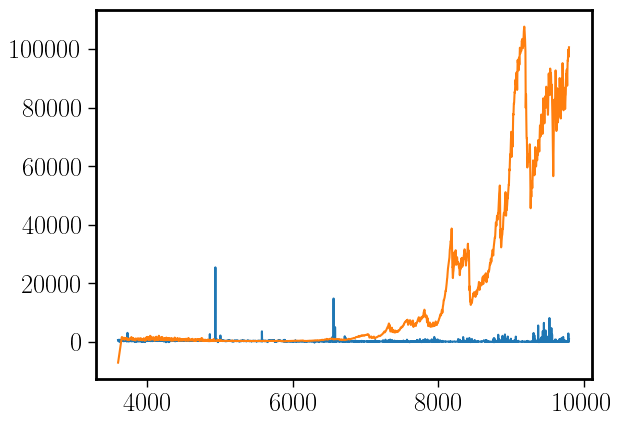

In [17]:
plt.plot(wave,org_spec)
plt.plot(wave,SPS.spectra['model_min'])

-> median error in flux = 0.0000
-> median error in flux = 0.0000
-> median raw flux = 280.8842 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 11.038589945243098
-> MED_FLUX: 280.88421630859375 +- 454.0773235204956 SN:11.038589945243098
- Redshift: 0.00000000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    1.00000000 +- 0.00000000
model_min_shape:  (12401,)
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4340-4340 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4101-4101 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113

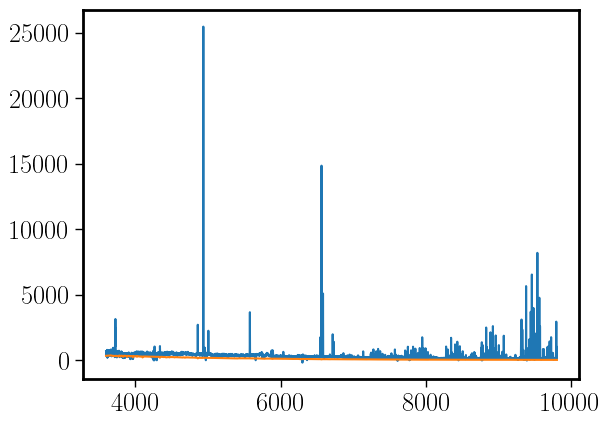

In [26]:
coeffs_now=0.0*coeffs_input
coeffs_now[0]=1

args.AV[0]=1
_, SPS = model_rsp_elines_single_main(
    wl__w, f__w, ef__w, args.rsp_file,  config_file, out_file, ssp_nl_fit_file=args.rsp_file,
    w_min=args.w_range[0], w_max=args.w_range[1], nl_w_min=args.w_range_nl[0],
    nl_w_max=args.w_range_nl[1], mask_list=args.mask_file,
    min=args.flux_scale[0], max=args.flux_scale[1], elines_mask_file=args.emission_lines_file,
    fit_gas=not args.ignore_gas, 
    input_redshift=args.redshift[0], delta_redshift=args.redshift[1], 
    min_redshift=args.redshift[2], max_redshift=args.redshift[3],
    input_sigma=args.sigma[0], delta_sigma=args.sigma[1], min_sigma=args.sigma[2], max_sigma=args.sigma[3],
    input_AV=args.AV[0], delta_AV=args.AV[1], min_AV=args.AV[2], max_AV=args.AV[3],
    sigma_inst=args.sigma_inst, plot=args.plot, sps_class=StellarSynthesis,
    coeffs_input=coeffs_now
)
i=0
SPS.output_gas_emission(filename=out_file_elines, spec_id=i)
SPS.output_coeffs_MC(filename=out_file_coeffs, write_header=i==0)
print(f'Teff test = {SPS.teff_min}')
SPS.output(filename=out_file_ps, write_header=i==0, block_plot=False)
model_spectra.append(SPS.output_spectra_list)

plt.plot(wave,org_spec)
plt.plot(wave,SPS.spectra['model_min'])


In [27]:
model_spectra = np.array(model_spectra).transpose(1, 0, 2)
dump_rss_output(out_file_fit=out_file_fit, wavelength=wl__w, model_spectra=model_spectra)

array([[[  687.652 ,   653.159 ,   590.4202, ...,   959.7869,   981.6826,  1012.1271],
        [  687.652 ,   653.159 ,   590.4202, ...,   959.7869,   981.6826,  1012.1271]],

       [[ 1216.4954,  1207.6342,  1198.7711, ...,  5084.0934,  5097.8097,  5113.1144],
        [  335.5171,   335.6917,   335.8664, ...,    24.6008,    24.4853,    24.3649]],

       [[ 1216.4954,  1207.6342,  1198.7711, ...,  5084.0934,  5097.8097,  5113.1144],
        [  335.5171,   335.6917,   335.8664, ...,    24.6008,    24.4853,    24.3649]],

       [[  687.652 ,   653.159 ,   590.4202, ...,   959.7869,   981.6826,  1012.1271],
        [  687.652 ,   653.159 ,   590.4202, ...,   959.7869,   981.6826,  1012.1271]],

       [[ -528.8435,  -554.4752,  -608.3509, ..., -4124.3065, -4116.1271, -4100.9873],
        [  352.1349,   317.4672,   254.5538, ...,   935.186 ,   957.1973,   987.7621]],

       [[  687.652 ,   653.159 ,   590.4202, ...,   959.7869,   981.6826,  1012.1271],
        [  687.652 ,   653.159 , 